# Install and import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tqdm.notebook import tqdm
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
%%capture
!pip install sentence-transformers
!pip install keybert
!pip install umap-learn

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
from keybert import KeyBERT
kw_model = KeyBERT()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Load and preprosess data

In [5]:
df = pd.read_csv('../input/myanimelist-dataset-animes-profiles-reviews/animes.csv')
df = df.reset_index() 
df.dropna(inplace=True, subset=['synopsis', 'title'])
df = df[~df.uid.duplicated(keep='first')]
df.head()

,index,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [6]:
# TITLE = 'Shingeki no Kyojin'
# title = TITLE
# doc = df[df['title'] == title].synopsis.values[0]
# doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
# paragraphs = [p for p in doc.split("\n") if len(p) > 50]
# doc = paragraphs[2]

In [7]:
TITLE = 'Shingeki no Kyojin'
idx = df[df['title'] == TITLE].index
def get_synopsis(ind):
    doc = df.loc[idx].synopsis.values[0]
    doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
    doc = doc.replace(u'\n', u'').replace(u'\r', u'')
    doc = nlp(doc)
    return doc
doc = get_synopsis(TITLE)
print(doc)

Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.  After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga,  Shingeki no Kyojin  

# Extract keyword candidates

In [8]:
for nph in doc.noun_chunks: # use np instead of np.text
    if len(nph) > 1:
        print('> ', nph)

>  monstrous humanoid creatures
>  enormous concentric walls
>  these giants
>  their taste
>  human flesh
>  their survival
>  the remnants
>  defensive barriers
>  one hundred years
>  a single titan encounter
>  that fragile calm
>  a colossal titan
>  the supposedly impregnable outer wall
>  the fight
>  the man-eating abominations
>  a horrific personal loss
>  the hands
>  the invading creatures
>  Eren Yeager
>  his life
>  their eradication
>  the Survey Corps
>  an elite military unit
>  the merciless humanoids
>  the protection
>  the walls
>  Hajime Isayama's award-winning manga
>  his adopted sister
>  Mikasa Ackerman
>  his childhood friend
>  Armin Arlert
>  the brutal war
>  the titans
>  a way
>  the last walls


In [9]:
def get_keyword_candidates(doc):
    # code to recursively combine nouns
    # 'We' is actually a pronoun but included in your question
    # hence the token.pos_ == "PRON" part in the last if statement
    # suggest you extract PRON separately like the noun-chunks above

    index = 0
    nounIndices = []
    for token in doc:
        if token.pos_ == 'NOUN':
            nounIndices.append(index)
        index = index + 1

#     print('Nouns found: ', len(nounIndices))

    candidates = []
    for idxValue in nounIndices:
        if not bool(doc[idxValue].left_edge.ent_type_):
            start = doc[idxValue].left_edge.i
        else:
            start = idxValue 

        if not bool(doc[idxValue].right_edge.ent_type_):
            finish = doc[idxValue].right_edge.i+1
        else:
            finish = idxValue + 1

        if finish-start > 0 and finish-start <7:
            span = doc[start : finish]
#             print('>', span)
            candidates.append(span.text)

    return candidates

candidates = get_keyword_candidates(doc)
print(candidates)

['Centuries', 'mankind', 'humanoid', 'monstrous humanoid creatures called titans', 'titans', 'humans', 'fear', 'enormous concentric walls', 'these giants', 'their taste for human flesh', 'human flesh', 'hunger', 'pleasure', 'their survival', 'the remnants of humanity', 'humanity', 'defensive barriers', 'years', 'a single titan encounter', 'that fragile calm', 'the supposedly impregnable outer wall', 'man', 'the man-eating abominations', 'a horrific personal loss', 'the hands of the invading creatures', 'the invading creatures', 'his life', 'their eradication', 'merciless', 'the protection of the walls', 'the walls', 'award', 'manga,  ', 'his adopted sister', 'his childhood friend', 'the titans and race', 'race', 'the last walls']


In [10]:
keywords = kw_model.extract_keywords(doc.text, candidates=candidates, 
                              use_mmr=True, diversity=0.7)

keywords

[('monstrous humanoid creatures called titans', 0.5308),
 ('the protection of the walls', 0.3215),
 ('hunger', 0.2733),
 ('their eradication', 0.3178),
 ('merciless', 0.166)]

## TODO: HDBSCAN

In [11]:
# from nltk import tokenize
# all_sents = []
# for syn in tqdm([doc]):
#     all_sents += tokenize.sent_tokenize(syn)
    
# for sentence in all_sents:
#     candidates = get_keyword_candidates(nlp(sentence))
#     keywords = kw_model.extract_keywords(sentence, candidates=candidates, 
#                               use_mmr=True, diversity=0.7)
#     print(keywords)

In [12]:
import umap
import umap.plot
reducer = umap.UMAP()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

keywords = np.

In [13]:
# keywords = np.load('../input/synopsis-keyword-clusterization/keywords.npy')
# keyword_embeddings = np.load('../input/synopsis-keyword-clusterization/keyword_embeddings.npy')
# ids = np.load('../input/synopsis-keyword-clusterization/ids.npy')
# with open('../input/synopsis-keyword-clusterization/reducer.pkl', 'rb') as f:
#     reducer = pickle.load(f)

In [14]:
keywords = []
keyword_embeddings = np.zeros((0,384))
ids = []

i = 0
row = df.synopsis[0]
for i, row in enumerate(tqdm(df.synopsis)):
    doc = row
    doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
    doc = doc.replace(u'\n', u'').replace(u'\r', u'')
    doc = nlp(doc)
    candidates = get_keyword_candidates(doc)
    syn_keywords = kw_model.extract_keywords(doc.text, candidates=candidates, 
                              use_mmr=True, diversity=0.7)
    syn_keywords = [k[0] for k in syn_keywords]
    if len(syn_keywords) > 0:
        keyword_embeddings = np.append(keyword_embeddings, kw_model.model.embed(syn_keywords), axis=0)
        keywords += syn_keywords
        ids += [i]

  0%|          | 0/15453 [00:00<?, ?it/s]

In [15]:
np.save('keywords', np.array(keywords))
np.save('keyword_embeddings', keyword_embeddings)
np.save('ids', np.array(ids))

In [16]:
%%time
reducer.fit(keyword_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CPU times: user 2min 50s, sys: 10 s, total: 3min
Wall time: 1min 7s


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [17]:
reduced = reducer.transform(keyword_embeddings)
# reduced = np.array(reduced)

<AxesSubplot:>

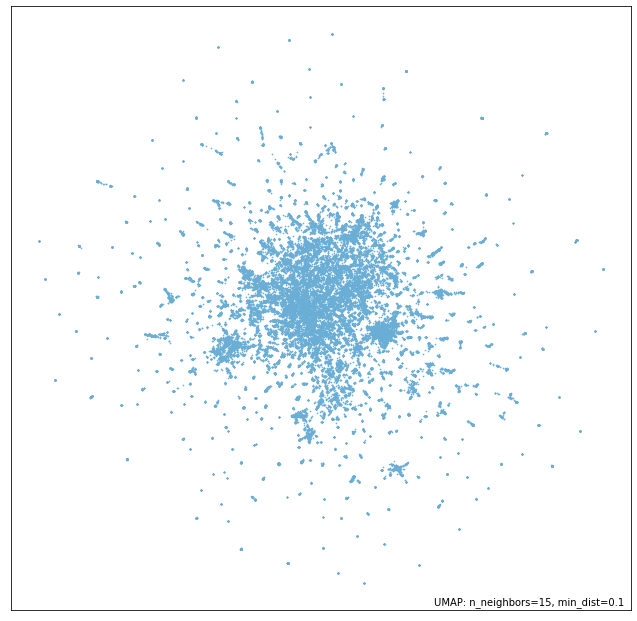

In [18]:
umap.plot.points(reducer)

In [19]:
with open('reducer.pkl', 'wb') as f:
    pickle.dump(reducer, f)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [20]:
from sklearn.cluster import DBSCAN

In [21]:
clustering = DBSCAN().fit(reduced)
y = clustering.labels_

In [22]:
results = pd.DataFrame()

In [23]:
results['class'] = y
results['keywords'] = keywords

In [24]:
results['class'].value_counts()

0      39447
30       409
4        285
25       263
6        245
       ...  
250        6
145        6
241        6
251        6
226        5
Name: class, Length: 252, dtype: int64

In [25]:
results[results['class']==5]

,class,keywords
64,5,ragtag
4131,5,this ragtag group of unlikely fighters
4891,5,a strange heart-shaped mirror
8276,5,a bizarre looking mirror
9921,5,Hiden room and double view mirrors
12561,5,madcap
13293,5,mirrors
13407,5,ragtag
14634,5,the rag-tag team
17182,5,a ragtag group
